In [12]:
%pip install openpyxl
%pip install missingno

Note: you may need to restart the kernel to use updated packages.
  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl (44.8 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from main_transformation import TransformationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
from gapminder import gapminder
import missingno as msno
import seaborn as sns

# Get data from Gapminder

In [4]:
df_population, df_gapminder = TransformationPipeline().run()

      country_code_a3  year                 country_name   population
0                 AFE  2023  Africa Eastern and Southern  739108306.0
1                 AFE  2022  Africa Eastern and Southern  720859132.0
2                 AFE  2021  Africa Eastern and Southern  702977106.0
3                 AFE  2020  Africa Eastern and Southern  685112979.0
4                 AFE  2019  Africa Eastern and Southern  667242986.0
...               ...   ...                          ...          ...
17019             ZWE  1964                     Zimbabwe    4310332.0
17020             ZWE  1963                     Zimbabwe    4177931.0
17021             ZWE  1962                     Zimbabwe    4049778.0
17022             ZWE  1961                     Zimbabwe    3925952.0
17023             ZWE  1960                     Zimbabwe    3806310.0

[17024 rows x 4 columns]

----- compute Population for each country and each zone
Please, check the following list :
['Middle East & North Africa (excluding hi

c:\Users\Utilisateur\Documents\GitHub\shiftdataportal\data-preparation\src\transformation\demographic\population.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_gapminder = df_gapminder.applymap(lambda element: self.dirty_string_to_int(element))


In [7]:
def display_unique_values(s:pd.Series, df:pd.DataFrame):
    n_unique_values = df.loc[s.name, "nbr_unique_values"]
    if n_unique_values == 0:
        return "no value"
    if n_unique_values < 6:
        return ", ".join(f"{s.value_counts().index[i]} ({v} occurrences)" for i, v in enumerate(s.value_counts()))
    
    return "too many to display"


def add_additional_comment(s:pd.Series, df:pd.DataFrame, sensitivity:float):   
    value_counts = s.value_counts()

    if len(value_counts) > 0:
        # Calculate top common values based on sensitivity
        n_top_common_values = int(len(value_counts) * sensitivity)
        top_common_values = value_counts.values[:n_top_common_values]
        
        # Check if the top common values represent a significant proportion of the data
        if value_counts.quantile(1 - sensitivity) / value_counts.max() < 0.25 and n_top_common_values <= 10:
            sum_top_common_values = top_common_values.sum()
            top_common_values_prop = round(sum_top_common_values / df.loc[s.name, "nbr_non_null_values"], 2)
            top_common_values_info = [f"{value_counts.index[i]} ({value})" for i, value in enumerate(top_common_values)]
            
            # Print additional comments on common values
            return f"""First {n_top_common_values} unique values represent {top_common_values_prop * 100}% of total values : {', '.join(top_common_values_info)}"""
        
        return
    
    else:
        return "This column only contains null values."


def compute_modes(s:pd.Series):
    value_counts = s.value_counts()
    modes = s.mode()
    n_modes = len(modes)

    if n_modes > 0:
        return ", ".join(str(v) if i < 3 else f"... ({n_modes} elements)" for i, v in enumerate(modes[:min(n_modes, 4)])) + f" ({value_counts.values[0]} occurrence(s))"
    
    return


def get_df_variables_info(df:pd.DataFrame) -> pd.DataFrame:

    (n_rows, n_columns) = df.shape
    print(f"This DataFrame has {n_rows} rows and {n_columns} columns.")
    
    top_common_values_sensitivity = 0.15

    n_unique_values = df.nunique()
    n_values = df.count()

    df_info = pd.DataFrame({
        'column_type':df.dtypes,
        'missing_value_percentage': (df.isnull().mean()*100).round(3),
        'nbr_unique_values': n_unique_values,
        'nbr_null_values': df.isnull().sum(),
        'nbr_non_null_values': n_values,
        'duplicates_percentage':round(100-n_unique_values/(n_values.where(n_values != 0, np.nan))*100, 2),
        'mode': df.apply(compute_modes),
        'min': df.min(numeric_only=True),
        'max': df.max(numeric_only=True),
        'mean': df.mean(numeric_only=True),
        'median': df.median(numeric_only=True),
        'std': df.std(numeric_only=True)
        })

    df_info["unique_values"] = df.apply(display_unique_values, df=df_info)
    df_info["additional_comment"] = df.apply(add_additional_comment, df=df_info, sensitivity=top_common_values_sensitivity)

    return df_info


In [10]:
df_population_info = get_df_variables_info(df_population)

This DataFrame has 14272 rows and 4 columns.


In [11]:
df_gapminder_info = get_df_variables_info(df_gapminder)

This DataFrame has 46398 rows and 4 columns.


In [14]:
df_gapminder["year"] = df_gapminder["year"].astype(int)

In [15]:
df_population["year"] = df_population["year"].astype(int)

In [16]:
df_population_info = get_df_variables_info(df_population)
df_gapminder_info = get_df_variables_info(df_gapminder)

This DataFrame has 14272 rows and 4 columns.
This DataFrame has 46398 rows and 4 columns.


What countries are present in one source but not the other ?

In [27]:
additional_countries_GM = list(set(df_gapminder["group_name"]) - set(df_population["group_name"]))
print(f"Here are the countries present in source 'GapMinder' but not in source 'WBD' :")
print('\n'.join(additional_countries_GM))

Here are the countries present in source 'GapMinder' but not in source 'WBD' :
Taiwan
North Korea
Vatican
Palestine


In [26]:
additional_countries_GM = list(set(df_population["group_name"]) - set(df_gapminder["group_name"]))
print("Here are the countries present in source 'WBD' but not in source 'GapMinder' :")
print('\n'.join(additional_countries_GM))

Here are the countries present in source 'WBD' but not in source 'GapMinder' :
Gibraltar
Turks and Caicos Islands
Aruba
New Caledonia
Bermuda
Guam
Kosovo
Greenland
American Samoa
Macao Special Administrative Region (China)
British Virgin Islands
Puerto Rico
Northern Mariana Islands
United States Virgin Islands
French Polynesia
Cayman Islands
Faeroe Islands


In [ ]:
sns.lineplot()

# Add country codes

## Helper function to get country codes

In [4]:
def get_country_code(country_name):
    try:
        country = pycountry.countries.search_fuzzy(country_name)
        return country[0].alpha_3
    except:
        return None

In [5]:
get_country_code("France")

'FRA'

## Create mapping table

In [1]:
all_countries = list(gapminder["country"].unique())
len(all_countries)

NameError: name 'gapminder' is not defined

In [10]:
country_mapping = []
for country in all_countries:
    country_mapping.append({"country":country,"country_code":get_country_code(country)})
country_mapping = pd.DataFrame(country_mapping)
country_mapping.head()

,country,country_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Angola,AGO
4,Argentina,ARG


## Merge with gapminder dataset

In [11]:
population_data = population_data.merge(country_mapping,on = "country")
population_data.head()

,year,country,pop,country_code
0,1952,Afghanistan,8425333,AFG
1,1957,Afghanistan,9240934,AFG
2,1962,Afghanistan,10267083,AFG
3,1967,Afghanistan,11537966,AFG
4,1972,Afghanistan,13079460,AFG


# CSV Export

In [17]:
population_data.to_csv("../../processed/population_gapminder.csv",index = False)

# Visualisation

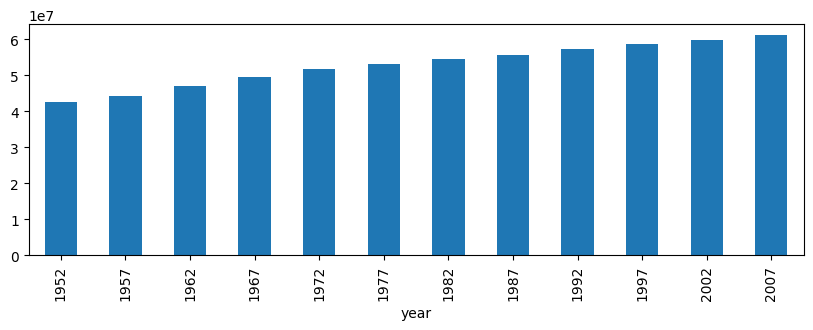

In [23]:
population_data.query("country_code=='FRA'").set_index("year")["pop"].plot(kind = "bar",figsize = (10,3))
plt.show()

# Note

## Gapminder does not have all the year included

## Gapminder includes GDP data as well

In [4]:
gapminder.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


## All the countries are not in Gapminder, total are not correct

> Gapminder dataset might not cover all countries, and the total population calculated using this dataset might not be equal to the actual world population.